In [17]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from genre_recommender import preprocess_popularity, recommend_top_movies_by_genres, show_recommendations, get_all_genres
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse import coo_matrix
# from lightfm import LightFM
# from lightfm.data import Dataset
# from lightfm.evaluation import precision_at_k
from tqdm import tqdm
import json
import os
import math
import glob
import dill
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN

## Что нужно сдеать

1. Сделать таблицу populatiry  на основе ratings (т.е сделать датасет с столбцами: movieId, ave_rating (находим как среднее по каждому фильму по рейтингу из imdb по imdbId)
2. Content-base:
- написать код выдачи топ -10 по populatiry (в соответствии с жанром)  - просто выдача по populatiry + жанр(ы)  (1)
- написать код выдачи рекомендации по фильмам. На 1 фильм - 10 рекомендаций.(без учета рейтинга) -рекомендашка (2)

3. User-base:
  - написать код выдачи рекомендации по фильму. На 1 фильм - 10 рекомендаций.(без учета рейтинга) и с изменением весов по тэгу-рекомендашка (3)
  - написать код выдачи рекомендации по фильму. На 1 фильм - 10 рекомендаций.(с учетом рейтинга) -рекомендашка (4)

## Работа с юзерами

1. Юзер новый и хочет рекомендаций- Юзер выбирает жанр и мы выдаем топ -5 по populatiry (в соответствии с жанром)
2. Юзер посмотрел несоклько фильмов - подбираем похожий фильм (жанр, и тэги с учетом их весов (relevance))
3. Юзер посмотрел несколько фильмов и поставил рейтинг менее 5 раз но больше 0. Фиксируем тэг фильмов на которые был поставлен рейтинг. И в зависимости от оценки уменьшаемили увеличиваем веса жанров/тэгов пропорционально оценке.
4. Юзер посмотрел несколько фильмов и поставил рейтинг 5+раз  - подбираем рекомендации ( в соответвии с его рейтингами)

# 1.топ -10 по populatiry (в соответствии с жанром) - просто выдача по populatiry + жанр(ы) (1)

In [16]:
popularity_df = preprocess_popularity(ratings)

# Непосредственно рекомендации
recommend_top_movies_by_genres("Action", "Adventure", movies_df=movies, popularity_df=popularity_df)

,title,genres,ave_rating,rating_count,weighted_rating
44066,Band of Brothers (2001),Action|Drama|War,4.423986,2835,4.419025
1930,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,4.250818,17120,4.250095
41020,Over the Garden Wall (2013),Adventure|Animation|Drama,4.256993,1430,4.248352
2867,Fight Club (1999),Action|Crime|Drama|Thriller,4.236019,86207,4.235877
82617,Spider-Man: Across the Spider-Verse (2023),Action|Adventure|Animation|Sci-Fi,4.252841,528,4.229790
5509,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,4.226035,35375,4.225692
55378,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,4.192053,10885,4.190971
12221,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.187539,65349,4.187359
887,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.187337,21883,4.186801
5905,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.183597,27209,4.183167


In [25]:
# Интерактивный режим 
show_recommendations(movies_df=movies, ratings_df=ratings)

## 2. Content-base:

In [4]:
# Подготовка данных

movies = pd.read_csv('content/films/movies.csv')
ratings = pd.read_csv('content/films/ratings.csv')
tags = pd.read_csv('content/films/tags.csv')
genome_tags = pd.read_csv('content/films/genome-tags.csv')
genome_scores = pd.read_csv('content/films/genome-scores.csv')

# Проверим размеры
print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("tags:", tags.shape)
print("genome_tags:", genome_tags.shape)
print("genome_scores:", genome_scores.shape)

movies: (86537, 3)
ratings: (33832162, 4)
tags: (2328315, 4)
genome_tags: (1128, 2)
genome_scores: (18472128, 3)


In [6]:
# Преобразуем genome_scores в широкую таблицу: movieId × tagId
movie_tag_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# Добавим к movie_tag_matrix названия тегов
tag_id_to_name = genome_tags.set_index('tagId')['tag']
movie_tag_matrix.columns = movie_tag_matrix.columns.map(tag_id_to_name)

# Проверим результат
print("movie_tag_matrix shape:", movie_tag_matrix.shape)
movie_tag_matrix.head(3)

movie_tag_matrix shape: (16376, 1128)


tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0320,0.02225,0.07000,0.05900,0.12300,0.1310,0.06175,0.19550,0.26625,0.03300,...,0.04125,0.01550,0.03775,0.03500,0.11525,0.04350,0.04050,0.03300,0.07700,0.01825
2,0.0325,0.03200,0.04050,0.05100,0.10050,0.0635,0.19825,0.07525,0.09750,0.06325,...,0.04100,0.02025,0.01100,0.01875,0.13425,0.01850,0.01825,0.00825,0.08750,0.01375
3,0.0415,0.05525,0.02125,0.07225,0.05125,0.0440,0.03000,0.10375,0.02300,0.03250,...,0.06175,0.01825,0.02375,0.01700,0.12400,0.02775,0.01600,0.01325,0.10075,0.01800


## Нормализация

In [8]:
scaler = MinMaxScaler()
movie_vectors_scaled = scaler.fit_transform(movie_tag_matrix)

print("Scaled shape:", movie_vectors_scaled.shape)

Scaled shape: (16376, 1128)


In [12]:
input_dim = movie_vectors_scaled.shape[1]  # 1128
encoding_dim = 64  # можно изменить на 128 или 32

# Входной слой
input_layer = Input(shape=(input_dim,))

# Кодировщик (encoder)
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Декодировщик (decoder)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Модель автоэнкодера
autoencoder = Model(input_layer, decoded)

# Модель энкодера (для извлечения признаков)
encoder = Model(input_layer, encoded)

# Компиляция
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение
history = autoencoder.fit(
    movie_vectors_scaled, movie_vectors_scaled,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0755 - val_loss: 0.0255
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0299 - val_loss: 0.0247
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0291 - val_loss: 0.0244
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0287 - val_loss: 0.0231
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0230 - val_loss: 0.0065
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0117 - val_loss: 0.0056
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0088 - val_loss: 0.0050
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

In [13]:
# Получаем сжатые векторы
movie_vectors_reduced = encoder.predict(movie_vectors_scaled)

# Проверим размерность
print("Reduced shape:", movie_vectors_reduced.shape)


512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reduced shape: (16376, 64)


In [ ]:
# Преобразуем в DataFrame и добавим movieId
movie_vectors_df = pd.DataFrame(movie_vectors_reduced)
movie_vectors_df['movieId'] = movie_tag_matrix.index.values



In [14]:
# Сохраняем с индексами
np.savez_compressed('content/films/movie_vectors_reduced.npz',
                    vectors=movie_vectors_reduced,
                    movie_ids=movie_tag_matrix.index.values)

print("Сжатые векторы фильмов сохранены в movie_vectors_reduced.npz")

Сжатые векторы фильмов сохранены в movie_vectors_reduced.npz


In [19]:
data = np.load('content/films/movie_vectors_reduced.npz')
movie_vectors_reduced = data['vectors']
movie_ids = data['movie_ids']


In [4]:
# Функция для получения 10 самых похожих фильмов
def get_similar_movies(movie_id, movie_vectors_reduced, top_n=10):
    cosine_sim = cosine_similarity(movie_vectors_reduced)  # Косинусное сходство
    movie_index = movie_id - 1  # Индексы начинаются с 0, а movie_id - с 1
    sim_scores = list(enumerate(cosine_sim[movie_index]))  # Список сходства
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Сортируем
    return sim_scores[1:top_n+1]  # Топ-N схожих фильмов


In [ ]:
def recommend_movies_with_strict_genres_filter(movie_ids, top_n=10, internal_top_n=50, mode='custom'):
    all_recommendations = []

    for movie_id in movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

        # Выбор метода получения похожих фильмов
        if mode == 'knn':
            similar_movies = get_similar_movies_knn(movie_id, movie_vectors_reduced, top_n=internal_top_n)
        else:
            similar_movies = get_similar_movies(movie_id, movie_vectors_reduced, top_n=internal_top_n)

        filtered_similar_movies = []
        for idx, score in similar_movies:
            movie_row = movies.iloc[idx]
            movie_title = movie_row['title']
            movie_genres = movie_row['genres']

            if pd.isna(movie_title) or pd.isna(movie_genres):
                continue

            movie_genres_set = set(movie_genres.split('|'))

            # Зануляем score, если нет пересечений по жанрам
            if not original_genres_set.intersection(movie_genres_set):
                score = 0

            filtered_similar_movies.append({
                'movie_id': movies.iloc[idx]['movieId'],
                'title': movie_title,
                'genres': movie_genres,
                'similarity_score': score
            })

        # Применяем взвешенные баллы
        for i, rec in enumerate(filtered_similar_movies):
            final_weight = rec['similarity_score']
            if i == 0:
                rec['weight'] = final_weight + 20
            elif i == 1:
                rec['weight'] = final_weight + 12
            elif i == 2:
                rec['weight'] = final_weight + 8
            elif i == 3:
                rec['weight'] = final_weight + 5
            elif i == 4:
                rec['weight'] = final_weight + 3
            else:
                rec['weight'] = final_weight + 1

        all_recommendations.extend(filtered_similar_movies)

    # Финальный расчёт баллов
    recommendations_df = pd.DataFrame(all_recommendations)
    if recommendations_df.empty:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    final_scores = recommendations_df.groupby('movie_id').agg({'weight': 'sum'}).reset_index()
    final_recommendations_df = final_scores.sort_values('weight', ascending=False).head(top_n)

    final_recommendations_df = final_recommendations_df.merge(
        movies[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title', 'genres'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']]

In [22]:
# Функция для расчета сходства жанров
def calculate_genre_similarity(genre1, genre2):
    genres1 = set(genre1.split('|'))
    genres2 = set(genre2.split('|'))
    
    # Рассчитываем пересечение жанров
    common_genres = genres1.intersection(genres2)
    
    # Схожесть будет равна отношению общего количества жанров к общему количеству жанров
    return len(common_genres) / len(genres1.union(genres2))

In [23]:
# Пример: рекомендации для фильма с ID = 1
movie_ids_to_check = [1, 10, 100]
top_n = 10  # Количество рекомендаций
final_recommendations_df = recommend_movies_with_strict_genres_filter(movie_ids_to_check, top_n)


# Выводим результат
final_recommendations_df

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movie_id,title,genres,weight
0,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,20.996246
1,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,20.987832
2,6656,Attack of the Puppet People (1958),Horror|Sci-Fi,20.000000
3,2794,European Vacation (aka National Lampoon's Euro...,Adventure|Comedy|Romance,12.995582
4,2626,Edge of Seventeen (1998),Comedy|Drama|Romance,12.993158
5,5786,Paid in Full (2002),Action|Drama,12.000000
6,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,8.994554
7,8874,Shaun of the Dead (2004),Comedy|Horror,8.000000
8,2912,"Limey, The (1999)",Crime|Drama|Thriller,8.000000
9,167,Feast of July (1995),Drama,5.991889


In [24]:
# Пример: рекомендации для фильма с ID = 1
movie_ids_to_check = [1]
top_n = 10  # Количество рекомендаций
final_recommendations_df_2 = recommend_movies_with_strict_genres_filter(movie_ids_to_check, top_n)


# Выводим результат
final_recommendations_df_2

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)


,movie_id,title,genres,weight
0,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,20.987832
1,5786,Paid in Full (2002),Action|Drama,12.000000
2,2912,"Limey, The (1999)",Crime|Drama|Thriller,8.000000
3,2196,Knock Off (1998),Action,5.000000
4,44655,"Trial of Joan of Arc, The (Procès de Jeanne d'...",Drama|War,3.000000
5,53318,Cashback (2006),Comedy|Drama|Romance,1.971462
6,7370,A Foreign Affair (2003),Comedy|Drama|Romance,1.970418
7,72612,"Fly, The (Légy, A) (1980)",Animation|Comedy,1.970037
8,54910,Behind the Mask: The Rise of Leslie Vernon (2006),Comedy|Horror|Thriller,1.965568
9,59143,Super High Me (2007),Comedy|Documentary,1.965460


## KNN

KNN (K-Nearest Neighbors)

Принцип работы: KNN — это метод, основанный на идее поиска ближайших соседей. Для рекомендации товаров или фильмов он ищет пользователей или элементы, которые наиболее похожи на заданного пользователя или фильм. Основные шаги:
Преобразование данных: Мы представляем каждый фильм или пользователя в виде вектора признаков (например, с использованием TF-IDF, меток жанра или других характеристик). Расстояние между объектами: Чтобы найти «похожие» объекты, мы измеряем расстояние (или схожесть) между векторами с использованием таких метрик, как евклидово расстояние, косинусная схожесть и другие.
Поиск ближайших соседей: Для конкретного пользователя или фильма KNN находит ближайших соседей (фильмов или пользователей), основываясь на выбранной метрике сходства.
Рекомендация: Для фильма или пользователя на основе схожести с другими объектами рекомендатор предсказывает, какие элементы он мог бы "нравиться" или какие фильмы могут ему подойти. Физический смысл: Модель ищет ближайших соседей на основе сходства признаков. Например, если фильм похож на другие по жанрам, актёрам, рейтингу, то пользователю могут порекомендовать эти фильмы. KNN можно представить как способ поиск похожих объектов в большом множестве данных.
Преимущества: Простота и интерпретируемость. Модель не требует обучения, потому что она просто использует данные для поиска ближайших соседей.
Недостатки: Высокая вычислительная нагрузка на больших данных, особенно при поиске по всей базе. Не всегда подходит для более сложных или скрытых зависимостей между объектами.


In [30]:
knn_model = NearestNeighbors(n_neighbors=51, metric='cosine')  # 50 + 1, потому что первый будет сам фильм
knn_model.fit(movie_vectors_reduced)

NearestNeighbors(metric='cosine', n_neighbors=51)

In [31]:
def get_similar_movies_knn(movie_id, movie_vectors, top_n=50):
    # Получаем индекс фильма
    movie_index = movies[movies['movieId'] == movie_id].index[0]

    # Находим ближайшие фильмы
    distances, indices = knn_model.kneighbors([movie_vectors[movie_index]], n_neighbors=top_n+1)

    # Возвращаем список (индекс, 1 - расстояние) — кроме самого себя
    similar_movies = []
    for i in range(1, len(indices[0])):  # пропускаем 0-й элемент (сам фильм)
        idx = indices[0][i]
        similarity_score = 1 - distances[0][i]  # чем меньше расстояние, тем выше сходство
        similar_movies.append((idx, similarity_score))
    
    return similar_movies

In [32]:
movie_ids_to_check = [1, 10, 100]

recommend_movies_with_strict_genres_filter(
    movie_ids=movie_ids_to_check,
    top_n=10,
    internal_top_n=50,
    mode='knn'
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movie_id,title,genres,weight
0,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,20.996246
1,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,20.987832
2,1184,Mediterraneo (1991),Comedy|Drama,20.977005
3,2794,European Vacation (aka National Lampoon's Euro...,Adventure|Comedy|Romance,12.995582
4,5786,Paid in Full (2002),Action|Drama,12.000000
5,65204,Chandu the Magician (1932),Action|Adventure|Fantasy|Sci-Fi,12.000000
6,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,8.994554
7,1141,Last Call (Hoogste tijd) (1995),Drama,8.974602
8,2912,"Limey, The (1999)",Crime|Drama|Thriller,8.000000
9,2237,Without Limits (1998),Drama,5.974312


## Попробуем AgglomerativeClustering

In [45]:
# 1. Кластеризация
def cluster_movies(movie_vectors_reduced, n_clusters=100):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering_model.fit_predict(movie_vectors_reduced)
    return cluster_labels

In [46]:
def recommend_movies_by_cluster_filtered(movie_ids, movie_vectors_reduced, movies, cluster_labels, top_n=10):
    all_recommendations = []

    for movie_id in movie_ids:
        try:
            # Получаем индекс фильма
            movie_idx = movies[movies['movieId'] == movie_id].index[0]
            movie_title = movies.iloc[movie_idx]['title']
            movie_genres = set(movies.iloc[movie_idx]['genres'].split('|'))

            # Получаем кластер
            cluster_label = cluster_labels[movie_idx]
            same_cluster_indices = np.where(cluster_labels == cluster_label)[0]
            same_cluster_indices = same_cluster_indices[same_cluster_indices != movie_idx]

            if len(same_cluster_indices) == 0:
                continue

            # Евклидовы расстояния
            distances = euclidean_distances(
                movie_vectors_reduced[movie_idx].reshape(1, -1),
                movie_vectors_reduced[same_cluster_indices]
            )[0]
            similarities = 1 / (1 + distances)

            for idx, score in zip(same_cluster_indices, similarities):
                title = movies.iloc[idx]['title']
                genres = movies.iloc[idx]['genres']
                genres_set = set(genres.split('|'))

                if pd.isna(title) or pd.isna(genres):
                    continue

                if not movie_genres.intersection(genres_set):
                    score = 0

                all_recommendations.append({
                    'movie_id': movies.iloc[idx]['movieId'],
                    'title': title,
                    'genres': genres,
                    'similarity_score': score
                })
        except IndexError:
            continue

    # Агрегируем и сортируем
    all_recommendations_df = pd.DataFrame(all_recommendations)
    if all_recommendations_df.empty:
        return all_recommendations_df

    all_recommendations_df = all_recommendations_df.groupby(['movie_id', 'title', 'genres']).agg({'similarity_score': 'sum'}).reset_index()
    all_recommendations_df = all_recommendations_df.sort_values('similarity_score', ascending=False).head(top_n)

    # Добавим веса 
    weights = [20, 12, 8, 5, 3, 2, 2, 1, 1, 1]
    all_recommendations_df['weight'] = weights[:len(all_recommendations_df)]

    return all_recommendations_df

In [47]:
# Кластеризуем фильмы
cluster_labels = cluster_movies(movie_vectors_reduced, n_clusters=100)

# Рекомендации для списка фильмов
movie_ids_to_check = [1, 10, 100]
recommend_movies_by_cluster_filtered(movie_ids_to_check, movie_vectors_reduced, movies, cluster_labels, top_n=10)


,movie_id,title,genres,similarity_score,weight
52,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,0.360900,20
96,2794,European Vacation (aka National Lampoon's Euro...,Adventure|Comedy|Romance,0.339488,12
103,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,0.313479,8
132,3696,Night of the Creeps (1986),Comedy|Horror|Sci-Fi|Thriller,0.264342,5
161,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,0.253869,3
146,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,0.229954,2
201,6695,Jeepers Creepers 2 (2003),Horror|Thriller,0.214032,2
45,1184,Mediterraneo (1991),Comedy|Drama,0.189812,1
42,1141,Last Call (Hoogste tijd) (1995),Drama,0.183063,1
246,8658,Zandalee (1991),Drama|Thriller,0.179778,1


## Ensemble из 3 методов:

In [54]:
def ensemble_recommendation(movie_ids_to_check, top_n=10):
    # Получаем рекомендации от KNN с фильтрацией по жанрам
    rec_knn = recommend_movies_with_strict_genres_filter(
        movie_ids=movie_ids_to_check,
        top_n=top_n,
        internal_top_n=50,
        mode='knn'  # для KNN
    )

    # Получаем рекомендации с использованием простого косинусного сходства
    rec_cosine = recommend_movies_with_strict_genres_filter(
        movie_ids=movie_ids_to_check,
        top_n=top_n,
        internal_top_n=50,
        mode='custom'  # обычное косинусное сходство
    )

    cluster_labels = cluster_movies(movie_vectors_reduced, n_clusters=100)
    
    # Получаем рекомендации от кластеризации
    rec_cluster = recommend_movies_by_cluster_filtered(
        movie_ids=movie_ids_to_check,
        movie_vectors_reduced=movie_vectors_reduced,
        movies=movies,
        cluster_labels=cluster_labels,
        top_n=top_n
    )

    # Объединяем все рекомендации
    all_recs = pd.concat([rec_knn, rec_cosine, rec_cluster], ignore_index=True)

    # Суммируем веса по movie_id
    combined_scores = all_recs.groupby('movie_id').agg({'weight': 'sum'}).reset_index()

    # Добавляем названия и жанры
    combined_scores = combined_scores.merge(
        movies[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title', 'genres'])

    # Возвращаем топ-N рекомендаций
    return combined_scores.sort_values('weight', ascending=False).head(top_n)[['movie_id', 'title', 'genres', 'weight']]

In [55]:
# Рекомендации для списка фильмов
movie_ids_to_check = [1, 10, 100]
ensemble_recommendation(movie_ids_to_check, top_n=10)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)
Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movie_id,title,genres,weight
3,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,61.992492
10,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,43.975665
6,2794,European Vacation (aka National Lampoon's Euro...,Adventure|Comedy|Romance,37.991163
7,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,25.989107
12,5786,Paid in Full (2002),Action|Drama,24.000000
2,1184,Mediterraneo (1991),Comedy|Drama,21.977005
13,6656,Attack of the Puppet People (1958),Horror|Sci-Fi,20.000000
8,2912,"Limey, The (1999)",Crime|Drama|Thriller,16.000000
5,2626,Edge of Seventeen (1998),Comedy|Drama|Romance,12.993158
17,65204,Chandu the Magician (1932),Action|Adventure|Fantasy|Sci-Fi,12.000000


## 3. User-base: Сделаю сразу ассамблею (простое сродство, KNN, кластеры)

In [70]:
def get_user_vector(user_id, viewed_movie_ids, ratings_df, movie_vectors, movie_id_map, rating_threshold=4.0):
    """
    Строит user_vector в зависимости от количества рейтингов и их качества.
    
    Параметры:
    - user_id: ID пользователя
    - viewed_movie_ids: список просмотренных movieId (может включать фильмы без оценки)
    - ratings_df: DataFrame с колонками ['userId', 'movieId', 'rating']
    - movie_vectors: массив векторов фильмов 
    - movie_id_map: словарь movieId → индекс в movie_vectors
    - rating_threshold: рейтинг, выше которого считается "положительный"
    
    Возвращает:
    - user_vector: numpy-вектор предпочтений пользователя
    - mode: 'view_based' или 'rating_based' (для дальнейшей логики)
    """

    for movie_id in viewed_movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))
    
        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    rated_movie_ids = set(user_ratings['movieId'])
    positive_ratings = user_ratings[user_ratings['rating'] >= rating_threshold]
    
    # Используем рейтинговую стратегию, если достаточно данных
    if len(user_ratings) >= 5 and len(positive_ratings) >= 3:
        vectors = []
        weights = []
        for _, row in user_ratings.iterrows():
            mid = row['movieId']
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
                weights.append(row['rating'])  # Вес = рейтинг
        if vectors:
            weighted_avg = np.average(vectors, axis=0, weights=weights)
            return weighted_avg, 'rating_based'
    else:
        # Используем просмотренные фильмы
        vectors = []
        for mid in viewed_movie_ids:
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
            return avg_vector, 'view_based'
    
    return None, 'no_data'

In [71]:
def recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10, mode='cosine'):
    """
    Делает рекомендации на основе вектора пользователя тремя способами:
    - mode='cosine': простое косинусное сходство
    - mode='knn': KNN по user_vector
    - mode='cluster': рекомендации из кластера пользователя

    Параметры:
    - user_vector: numpy-вектор предпочтений пользователя
    - movie_vectors: матрица векторов фильмов
    - movies_df: DataFrame с колонками ['movieId', 'title', 'genres']
    - clustering_labels: массив меток кластеров для каждого фильма (нужен для mode='cluster')
    - top_n: количество рекомендаций
    - mode: 'cosine' | 'knn' | 'cluster'

    Возвращает:
    - DataFrame с колонками ['movieId', 'title', 'genres', 'score']
    """


    if user_vector is None:
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'score'])

    if mode == 'cosine':
        similarities = cosine_similarity([user_vector], movie_vectors)[0]
        top_indices = similarities.argsort()[::-1][:top_n]
        scores = similarities[top_indices]

    elif mode == 'knn':
        knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
        knn.fit(movie_vectors)
        distances, indices = knn.kneighbors([user_vector])
        top_indices = indices[0]
        scores = 1 - distances[0]  # cos-дистанция -> сходство

    elif mode == 'cluster':
        if clustering_labels is None:
            raise ValueError("Для кластеризации необходимо передать clustering_labels")

        from sklearn.metrics.pairwise import euclidean_distances
        # Определяем ближайший кластер
        cluster_id = clustering_labels[np.argmin(euclidean_distances([user_vector], movie_vectors))]
        cluster_indices = np.where(clustering_labels == cluster_id)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        similarities = cosine_similarity([user_vector], cluster_vectors)[0]
        top_indices_in_cluster = similarities.argsort()[::-1][:top_n]
        top_indices = cluster_indices[top_indices_in_cluster]
        scores = similarities[top_indices_in_cluster]

    else:
        raise ValueError("Неверный mode. Используйте: 'cosine', 'knn', 'cluster'")

    result_df = movies_df.iloc[top_indices].copy()
    result_df['score'] = scores
    return result_df[['movieId', 'title', 'genres', 'score']]

In [72]:
def ensemble_user_recommendations(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10):
    """
    Собирает рекомендации из 3 методов: cosine, knn, cluster → делает ensemble.
    
    Возвращает top_n рекомендаций по объединённому score.
    """

   

    rec_cosine = recommend_for_user(user_vector, movie_vectors, movies_df, mode='cosine', top_n=top_n * 2)
    rec_knn = recommend_for_user(user_vector, movie_vectors, movies_df, mode='knn', top_n=top_n * 2)
    rec_cluster = recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=clustering_labels, mode='cluster', top_n=top_n * 2)

    # Объединяем все рекомендации
    all_recs = pd.concat([rec_cosine, rec_knn, rec_cluster], axis=0)

    # Суммируем score по movieId
    combined = (
        all_recs.groupby('movieId')
        .agg({
            'score': 'sum',
            'title': 'first',
            'genres': 'first'
        })
        .reset_index()
    )

    # Сортируем и выбираем топ-N
    combined = combined.sort_values('score', ascending=False).head(top_n)
    return combined[['movieId', 'title', 'genres', 'score']]

In [76]:
user_vector, mode = get_user_vector(
    user_id=1,
    viewed_movie_ids=[1, 10, 100],
    ratings_df=ratings,
    movie_vectors=movie_vectors_reduced,
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])}
)
final_recommendations = ensemble_user_recommendations(
    user_vector,
    movie_vectors_reduced,
    movies,
    clustering_labels=cluster_labels,
    top_n=10
)
final_recommendations

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movieId,title,genres,score
37,86412,That's What I Am (2011),Children|Comedy,2.982625
8,80160,"Flintstone Kids' Just Say No Special, The (1988)",Animation|Children,1.988295
36,86190,Hanna (2011),Action|Adventure|Mystery|Thriller,1.987912
1,78088,Buried (2010),Mystery|Thriller,1.986712
13,80984,Rogue Cop (1954),Crime|Drama|Film-Noir,1.986586
18,81806,Vlad Tepes (Vlad &#354;epe&#351;) (1979),Drama,1.986568
34,85312,"House of Small Cubes, The (Tsumiki no ie) (2008)",Animation|Drama,1.985593
12,80761,"Crimson Wing: Mystery of the Flamingos, The (2...",Documentary,1.985462
16,81355,"Employment, The (Empleo, El) (2008)",Animation|Comedy|Drama,1.985326
35,85618,Noah's Ark (1928),Drama|War,1.985206


## Попробуем ALS

ALS (Alternating Least Squares)
- Принцип работы:
ALS — это метод матричной факторизации, который активно используется для рекомендательных систем, особенно в тех случаях, когда у нас есть большая матрица взаимодействий между пользователями и объектами (например, фильмы и оценки).
- Матрица взаимодействий:
Есть большая матрица, где строки — это пользователи, а столбцы — это объекты (например, фильмы). Каждое значение в ячейке — это взаимодействие пользователя с объектом (например, оценка фильма).
- Матричная факторизация:
ALS пытается разложить эту матрицу на две меньшие матрицы: одну для пользователей и одну для объектов. Эти матрицы называются факторами.
Идея заключается в том, чтобы найти скрытые представления (факторы), которые могут объяснить взаимодействия между пользователями и объектами. Модель ищет структуру в данных и пытается понять, какие скрытые факторы (например, предпочтения пользователя, жанры фильмов) влияют на взаимодействия.
- Чередующиеся минимизации (Alternating):
ALS поочередно фиксирует одну из матриц (например, матрицу факторов пользователей) и минимизирует ошибку по другой (например, матрице факторов объектов), и наоборот. Это называется чередующейся минимизацией (alternating minimization).
Алгоритм выполняет итерации, обновляя матрицы, пока ошибка (разница между предсказанными и реальными оценками) не станет минимальной.
- Физический смысл:
Это метод выделения скрытых факторов, которые объясняют поведение пользователей. В контексте фильмов это может быть жанровые предпочтения, актерский состав, тематика или другие факторы, которые влияют на предпочтения.
Таким образом, ALS пытается понять, что пользователи «ценят» в фильмах, и на основе этого делать предсказания.
- Преимущества:
Эффективен для работы с большими наборами данных, где взаимодействий (оценок) немного.
Подходит для задач, где важно выделить скрытые зависимости между пользователями и объектами.
- Недостатки:
Требует времени на обучение и вычисления, особенно для больших данных.
Может давать плохие результаты, если данные плохо распределены или если данные разрежены.

In [115]:
# Преобразуем userId и movieId в числовые индексы
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])

# Сохраняем маппинг обратно
user_id_map = dict(enumerate(user_encoder.classes_))
movie_id_map = dict(enumerate(item_encoder.classes_))


In [103]:
# Создание sparse-матрицы (user-item взаимодействий)
ratings_matrix = csr_matrix((
    ratings['rating'].values,
    (ratings['user_idx'].values, ratings['item_idx'].values)
))

In [116]:
# Создаем и обучаем ALS модель
als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.1,
    iterations=10,
    use_gpu=False  # Если есть GPU, установите True
)

# Обучаем модель на исходной матрице без транспонирования
als_model.fit(ratings_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
print(ratings_matrix.shape)

(330975, 83239)


In [123]:
user_internal_id =1

# Получаем строку взаимодействий для конкретного пользователя
user_interaction = ratings_matrix[user_internal_id]

# Получаем рекомендации для пользователя с user_internal_id
recommended_items = als_model.recommend(user_internal_id, user_interaction, N=10)

# Получаем ID фильмов и преобразуем их в реальные ID
recommended_movie_ids = [movie_id_map[item_id] for item_id in recommended_items[0]]

# Фильтруем фильмы, чтобы оставить только те, которые рекомендуются
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

# Отображаем результат
recommended_movies[['movieId', 'title', 'genres']]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
61,62,Mr. Holland's Opus (1995),Drama
312,316,Stargate (1994),Action|Adventure|Sci-Fi
324,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi
363,368,Maverick (1994),Adventure|Comedy|Western
405,410,Addams Family Values (1993),Children|Comedy|Fantasy
430,435,Coneheads (1993),Comedy|Sci-Fi
469,474,In the Line of Fire (1993),Action|Thriller
503,508,Philadelphia (1993),Drama
721,736,Twister (1996),Action|Adventure|Romance|Thriller


## MF — это Non-negative Matrix Factorization

- Алгоритм NMF — это Non-negative Matrix Factorization (Ненегативная матричная факторизация). Это метод разложения матрицы на две более простые, при условии, что все значения в этих матрицах неотрицательные.
Он часто используется в рекомендательных системах, тематическом моделировании и других задачах, где данные не могут быть отрицательными — например, рейтинги фильмов, частоты слов и т.д.

💡 Что делает NMF?
Предположим, у нас есть матрица рейтингов R размера (users x items) — например:
R ≈ U × V
R — исходная матрица рейтингов (пользователь × фильм)
U — матрица пользователей в "скрытом" пространстве (users × features)
V — матрица фильмов в том же пространстве (features × items)

Значения в U и V — неотрицательные (≥ 0).
Идея в том, что каждый пользователь и каждый товар описываются набором неотрицательных признаков (например, предпочтения по жанрам, стилю и т.д.), и произведение этих матриц приближает реальные рейтинги.

📊 Пример интуитивно
Допустим, ты — пользователь, который любит:
Комедии — 0.9
Экшн — 0.1
А фильм описывается как:
Комедия — 0.8
Экшн — 0.2

0.9 * 0.8 + 0.1 * 0.2 = 0.74
🧠 Почему NMF интересен?
В отличие от ALS или SVD, он интерпретируемый — можно понять, какие "темы" или "жанры" отвечают за предпочтения.
Очень хорошо работает в задачах, где отрицательные значения не имеют смысла.
Можно применять к спарс-матрицам (много пропущенных данных — обычное дело в рекомендациях).

In [4]:
# 1. Шаг 1: Подготовка данных

# Создаем матрицу взаимодействий (userId × movieId)
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()


In [5]:
# Создание разреженной матрицы взаимодействий (user × item)
print(f"Создаем разреженную матрицу {n_users}×{n_items}...")
ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx'])),
    shape=(n_users, n_items)
)

ratings_csr = ratings_coo.tocsr()

print("Готово: разреженная матрица создана!")

Создаем разреженную матрицу 330975×83239...
Готово: разреженная матрица создана!


In [6]:
# Шаг 2: Обучаем NMF
nmf_model = NMF(n_components=50, init='nndsvda', random_state=42, max_iter=100)
user_factors = nmf_model.fit_transform(ratings_csr)
item_factors = nmf_model.components_

/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [7]:
# Сохраняем с компрессией
np.savez_compressed('content/films/user_factors_compressed.npz', X=user_factors)
print(f"[✔] Сжатый user_factors сохранён")

np.savez_compressed('content/films/item_factors_compressed.npz', X=item_factors)
print(f"[✔] Сжатый item_factors сохранён")

[✔] Сжатый user_factors сохранён
[✔] Сжатый item_factors сохранён


In [6]:
# Загружаем сжатые данные
user_factors = np.load('content/films/user_factors_compressed.npz')['X']
item_factors = np.load('content/films/item_factors_compressed.npz')['X']
print(f"[✔] Данные загружены")

[✔] Данные загружены


In [29]:
def save_recommendation_chunks(user_factors, item_factors, chunk_size=200, top_n=100, save_dir="content/films/recommendations/recommendation_chunks"):
    os.makedirs(save_dir, exist_ok=True)

    n_users = user_factors.shape[0]
    n_items = item_factors.shape[0]
    n_components = item_factors.shape[1]

    print(f"Размерность item_factors: {item_factors.shape}")  # Добавляем отладочную информацию
    
    for start_idx in tqdm(range(0, n_users, chunk_size), desc="Сохраняем чанки"):
        end_idx = min(start_idx + chunk_size, n_users)
        
        chunk_user_factors = user_factors[start_idx:end_idx]  # (chunk_size, n_components)
        
        # # Перемножаем (chunk_size, n_components) на (n_components, n_items)
        # print(f"Размерность chunk_user_factors: {chunk_user_factors.shape}")  # Отладочная информация
        # print(f"Размерность item_factors: {item_factors.shape}")  # Отладочная информация
        
        chunk_scores = chunk_user_factors @ item_factors  # (chunk_size, n_items)
        
        recs_dict = {}
        for local_i in range(chunk_scores.shape[0]):
            global_user_id = start_idx + local_i
            top_n_indices = np.argsort(-chunk_scores[local_i])[:top_n]
            recs_dict[global_user_id] = top_n_indices.tolist()

        filename = os.path.join(save_dir, f"recs_chunk_{start_idx}_{end_idx}.dll")

        # Сохраняем данные с использованием dill
        with open(filename, 'wb') as f:
            dill.dump(recs_dict, f)

        print(f"✅ Сохранён чанк: {filename}")

    print("🎉 Все чанки успешно сохранены.")


In [30]:
save_recommendation_chunks(user_factors, item_factors, chunk_size=2000, top_n=100)

Размерность item_factors: (50, 83239)


Сохраняем чанки:   1%|█▌                                                                                                                                                                                                                                                            | 1/166 [00:10<28:12, 10.26s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_0_2000.dll


Сохраняем чанки:   1%|███                                                                                                                                                                                                                                                           | 2/166 [00:20<28:22, 10.38s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_2000_4000.dll


Сохраняем чанки:   2%|████▌                                                                                                                                                                                                                                                         | 3/166 [00:30<27:28, 10.11s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_4000_6000.dll


Сохраняем чанки:   2%|██████                                                                                                                                                                                                                                                        | 4/166 [00:40<27:19, 10.12s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_6000_8000.dll


Сохраняем чанки:   3%|███████▋                                                                                                                                                                                                                                                      | 5/166 [00:50<27:08, 10.12s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_8000_10000.dll


Сохраняем чанки:   4%|█████████▏                                                                                                                                                                                                                                                    | 6/166 [01:00<26:42, 10.02s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_10000_12000.dll


Сохраняем чанки:   4%|██████████▋                                                                                                                                                                                                                                                   | 7/166 [01:11<27:10, 10.26s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_12000_14000.dll


Сохраняем чанки:   5%|████████████▏                                                                                                                                                                                                                                                 | 8/166 [01:22<27:27, 10.43s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_14000_16000.dll


Сохраняем чанки:   5%|█████████████▊                                                                                                                                                                                                                                                | 9/166 [01:32<27:06, 10.36s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_16000_18000.dll


Сохраняем чанки:   6%|███████████████▏                                                                                                                                                                                                                                             | 10/166 [01:42<26:41, 10.27s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_18000_20000.dll


Сохраняем чанки:   7%|████████████████▊                                                                                                                                                                                                                                            | 11/166 [01:52<26:33, 10.28s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_20000_22000.dll


Сохраняем чанки:   7%|██████████████████▎                                                                                                                                                                                                                                          | 12/166 [02:03<26:28, 10.31s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_22000_24000.dll


Сохраняем чанки:   8%|███████████████████▊                                                                                                                                                                                                                                         | 13/166 [02:13<26:06, 10.24s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_24000_26000.dll


Сохраняем чанки:   8%|█████████████████████▎                                                                                                                                                                                                                                       | 14/166 [02:23<25:44, 10.16s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_26000_28000.dll


Сохраняем чанки:   9%|██████████████████████▊                                                                                                                                                                                                                                      | 15/166 [02:33<25:30, 10.14s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_28000_30000.dll


Сохраняем чанки:  10%|████████████████████████▍                                                                                                                                                                                                                                    | 16/166 [02:43<25:05, 10.03s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_30000_32000.dll


Сохраняем чанки:  10%|█████████████████████████▉                                                                                                                                                                                                                                   | 17/166 [02:53<25:06, 10.11s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_32000_34000.dll


Сохраняем чанки:  11%|███████████████████████████▍                                                                                                                                                                                                                                 | 18/166 [03:03<24:42, 10.02s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_34000_36000.dll


Сохраняем чанки:  11%|████████████████████████████▉                                                                                                                                                                                                                                | 19/166 [03:12<24:22,  9.95s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_36000_38000.dll


Сохраняем чанки:  12%|██████████████████████████████▍                                                                                                                                                                                                                              | 20/166 [03:23<24:21, 10.01s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_38000_40000.dll


Сохраняем чанки:  13%|████████████████████████████████                                                                                                                                                                                                                             | 21/166 [03:33<24:21, 10.08s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_40000_42000.dll


Сохраняем чанки:  13%|█████████████████████████████████▌                                                                                                                                                                                                                           | 22/166 [03:43<23:58,  9.99s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_42000_44000.dll


Сохраняем чанки:  14%|███████████████████████████████████                                                                                                                                                                                                                          | 23/166 [03:52<23:44,  9.96s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_44000_46000.dll


Сохраняем чанки:  14%|████████████████████████████████████▌                                                                                                                                                                                                                        | 24/166 [04:02<23:32,  9.94s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_46000_48000.dll


Сохраняем чанки:  15%|██████████████████████████████████████                                                                                                                                                                                                                       | 25/166 [04:12<23:04,  9.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_48000_50000.dll


Сохраняем чанки:  16%|███████████████████████████████████████▋                                                                                                                                                                                                                     | 26/166 [04:22<22:53,  9.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_50000_52000.dll


Сохраняем чанки:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                   | 27/166 [04:32<22:45,  9.83s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_52000_54000.dll


Сохраняем чанки:  17%|██████████████████████████████████████████▋                                                                                                                                                                                                                  | 28/166 [04:41<22:26,  9.76s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_54000_56000.dll


Сохраняем чанки:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                | 29/166 [04:51<22:18,  9.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_56000_58000.dll


Сохраняем чанки:  18%|█████████████████████████████████████████████▋                                                                                                                                                                                                               | 30/166 [05:01<22:06,  9.76s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_58000_60000.dll


Сохраняем чанки:  19%|███████████████████████████████████████████████▏                                                                                                                                                                                                             | 31/166 [05:11<22:03,  9.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_60000_62000.dll


Сохраняем чанки:  19%|████████████████████████████████████████████████▊                                                                                                                                                                                                            | 32/166 [05:21<22:04,  9.88s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_62000_64000.dll


Сохраняем чанки:  20%|██████████████████████████████████████████████████▎                                                                                                                                                                                                          | 33/166 [05:30<21:43,  9.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_64000_66000.dll


Сохраняем чанки:  20%|███████████████████████████████████████████████████▊                                                                                                                                                                                                         | 34/166 [05:40<21:35,  9.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_66000_68000.dll


Сохраняем чанки:  21%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 35/166 [05:50<21:26,  9.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_68000_70000.dll


Сохраняем чанки:  22%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 36/166 [06:00<21:12,  9.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_70000_72000.dll


Сохраняем чанки:  22%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 37/166 [06:09<20:59,  9.76s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_72000_74000.dll


Сохраняем чанки:  23%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 38/166 [06:19<20:52,  9.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_74000_76000.dll


Сохраняем чанки:  23%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 39/166 [06:29<20:37,  9.74s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_76000_78000.dll


Сохраняем чанки:  24%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 40/166 [06:39<20:30,  9.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_78000_80000.dll


Сохраняем чанки:  25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 41/166 [06:48<20:22,  9.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_80000_82000.dll


Сохраняем чанки:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 42/166 [06:58<20:11,  9.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_82000_84000.dll


Сохраняем чанки:  26%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 43/166 [07:08<20:08,  9.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_84000_86000.dll


Сохраняем чанки:  27%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 44/166 [07:18<19:54,  9.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_86000_88000.dll


Сохраняем чанки:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 45/166 [07:27<19:34,  9.70s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_88000_90000.dll


Сохраняем чанки:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 46/166 [07:37<19:35,  9.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_90000_92000.dll


Сохраняем чанки:  28%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 47/166 [07:47<19:36,  9.89s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_92000_94000.dll


Сохраняем чанки:  29%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 48/166 [07:57<19:16,  9.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_94000_96000.dll


Сохраняем чанки:  30%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 49/166 [08:07<19:16,  9.88s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_96000_98000.dll


Сохраняем чанки:  30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 50/166 [08:17<19:01,  9.84s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_98000_100000.dll


Сохраняем чанки:  31%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 51/166 [08:27<18:43,  9.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_100000_102000.dll


Сохраняем чанки:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 52/166 [08:36<18:35,  9.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_102000_104000.dll


Сохраняем чанки:  32%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 53/166 [08:46<18:18,  9.72s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_104000_106000.dll


Сохраняем чанки:  33%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 54/166 [08:56<18:25,  9.87s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_106000_108000.dll


Сохраняем чанки:  33%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 55/166 [09:06<18:11,  9.83s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_108000_110000.dll


Сохраняем чанки:  34%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 56/166 [09:16<17:56,  9.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_110000_112000.dll


Сохраняем чанки:  34%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 57/166 [09:25<17:48,  9.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_112000_114000.dll


Сохраняем чанки:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 58/166 [09:35<17:46,  9.88s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_114000_116000.dll


Сохраняем чанки:  36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 59/166 [09:45<17:35,  9.86s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_116000_118000.dll


Сохраняем чанки:  36%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 60/166 [09:55<17:23,  9.85s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_118000_120000.dll


Сохраняем чанки:  37%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 61/166 [10:05<17:19,  9.90s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_120000_122000.dll


Сохраняем чанки:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 62/166 [10:15<17:17,  9.97s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_122000_124000.dll


Сохраняем чанки:  38%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 63/166 [10:25<17:01,  9.92s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_124000_126000.dll


Сохраняем чанки:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 64/166 [10:35<16:44,  9.85s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_126000_128000.dll


Сохраняем чанки:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 65/166 [10:44<16:30,  9.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_128000_130000.dll


Сохраняем чанки:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 66/166 [10:54<16:25,  9.85s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_130000_132000.dll


Сохраняем чанки:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 67/166 [11:05<16:26,  9.96s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_132000_134000.dll


Сохраняем чанки:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 68/166 [11:15<16:33, 10.14s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_134000_136000.dll


Сохраняем чанки:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 69/166 [11:27<17:13, 10.66s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_136000_138000.dll


Сохраняем чанки:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 70/166 [11:39<17:40, 11.05s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_138000_140000.dll


Сохраняем чанки:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 71/166 [11:51<17:44, 11.20s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_140000_142000.dll


Сохраняем чанки:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 72/166 [12:02<17:50, 11.39s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_142000_144000.dll


Сохраняем чанки:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 73/166 [12:14<17:50, 11.52s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_144000_146000.dll


Сохраняем чанки:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 74/166 [12:26<17:52, 11.66s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_146000_148000.dll


Сохраняем чанки:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 75/166 [12:38<17:45, 11.71s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_148000_150000.dll


Сохраняем чанки:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 76/166 [12:50<17:29, 11.66s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_150000_152000.dll


Сохраняем чанки:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 77/166 [13:01<17:12, 11.60s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_152000_154000.dll


Сохраняем чанки:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 78/166 [13:13<17:09, 11.70s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_154000_156000.dll


Сохраняем чанки:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 79/166 [13:25<16:58, 11.71s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_156000_158000.dll


Сохраняем чанки:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 80/166 [13:37<16:51, 11.76s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_158000_160000.dll


Сохраняем чанки:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 81/166 [13:48<16:36, 11.72s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_160000_162000.dll


Сохраняем чанки:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 82/166 [14:00<16:19, 11.66s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_162000_164000.dll


Сохраняем чанки:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 83/166 [14:12<16:19, 11.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_164000_166000.dll


Сохраняем чанки:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 84/166 [14:24<16:05, 11.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_166000_168000.dll


Сохраняем чанки:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 85/166 [14:35<15:54, 11.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_168000_170000.dll


Сохраняем чанки:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 86/166 [14:47<15:33, 11.67s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_170000_172000.dll


Сохраняем чанки:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 87/166 [14:58<15:22, 11.68s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_172000_174000.dll


Сохраняем чанки:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 88/166 [15:10<15:14, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_174000_176000.dll


Сохраняем чанки:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 89/166 [15:22<15:02, 11.72s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_176000_178000.dll


Сохраняем чанки:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 90/166 [15:34<14:55, 11.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_178000_180000.dll


Сохраняем чанки:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 91/166 [15:46<14:39, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_180000_182000.dll


Сохраняем чанки:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 92/166 [15:57<14:18, 11.61s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_182000_184000.dll


Сохраняем чанки:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 93/166 [16:08<13:50, 11.38s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_184000_186000.dll


Сохраняем чанки:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 94/166 [16:19<13:38, 11.37s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_186000_188000.dll


Сохраняем чанки:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 95/166 [16:30<13:27, 11.37s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_188000_190000.dll


Сохраняем чанки:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 96/166 [16:42<13:23, 11.48s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_190000_192000.dll


Сохраняем чанки:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 97/166 [16:54<13:09, 11.45s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_192000_194000.dll


Сохраняем чанки:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 98/166 [17:05<13:05, 11.56s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_194000_196000.dll


Сохраняем чанки:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 99/166 [17:17<12:49, 11.49s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_196000_198000.dll


Сохраняем чанки:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 100/166 [17:28<12:43, 11.57s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_198000_200000.dll


Сохраняем чанки:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 101/166 [17:40<12:35, 11.62s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_200000_202000.dll


Сохраняем чанки:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 102/166 [17:52<12:22, 11.60s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_202000_204000.dll


Сохраняем чанки:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 103/166 [18:03<12:10, 11.60s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_204000_206000.dll


Сохраняем чанки:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 104/166 [18:15<11:54, 11.52s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_206000_208000.dll


Сохраняем чанки:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 105/166 [18:26<11:47, 11.59s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_208000_210000.dll


Сохраняем чанки:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 106/166 [18:38<11:41, 11.70s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_210000_212000.dll


Сохраняем чанки:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 107/166 [18:50<11:28, 11.67s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_212000_214000.dll


Сохраняем чанки:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 108/166 [19:02<11:17, 11.68s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_214000_216000.dll


Сохраняем чанки:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 109/166 [19:13<11:06, 11.69s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_216000_218000.dll


Сохраняем чанки:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 110/166 [19:25<10:55, 11.70s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_218000_220000.dll


Сохраняем чанки:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 111/166 [19:37<10:53, 11.89s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_220000_222000.dll


Сохраняем чанки:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 112/166 [19:49<10:42, 11.90s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_222000_224000.dll


Сохраняем чанки:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 113/166 [20:01<10:26, 11.83s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_224000_226000.dll


Сохраняем чанки:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 114/166 [20:13<10:23, 11.99s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_226000_228000.dll


Сохраняем чанки:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 115/166 [20:25<10:12, 12.02s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_228000_230000.dll


Сохраняем чанки:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 116/166 [20:37<09:55, 11.91s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_230000_232000.dll


Сохраняем чанки:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 117/166 [20:49<09:42, 11.88s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_232000_234000.dll


Сохраняем чанки:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 118/166 [21:01<09:25, 11.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_234000_236000.dll


Сохраняем чанки:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 119/166 [21:12<09:15, 11.83s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_236000_238000.dll


Сохраняем чанки:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 120/166 [21:24<08:59, 11.72s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_238000_240000.dll


Сохраняем чанки:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 121/166 [21:36<08:51, 11.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_240000_242000.dll


Сохраняем чанки:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 122/166 [21:47<08:33, 11.68s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_242000_244000.dll


Сохраняем чанки:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 123/166 [21:59<08:24, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_244000_246000.dll


Сохраняем чанки:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 124/166 [22:11<08:17, 11.84s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_246000_248000.dll


Сохраняем чанки:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 125/166 [22:23<08:02, 11.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_248000_250000.dll


Сохраняем чанки:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 126/166 [22:35<07:52, 11.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_250000_252000.dll


Сохраняем чанки:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 127/166 [22:46<07:35, 11.69s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_252000_254000.dll


Сохраняем чанки:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 128/166 [22:58<07:29, 11.84s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_254000_256000.dll


Сохраняем чанки:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 129/166 [23:10<07:17, 11.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_256000_258000.dll


Сохраняем чанки:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 130/166 [23:22<07:02, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_258000_260000.dll


Сохраняем чанки:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 131/166 [23:33<06:50, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_260000_262000.dll


Сохраняем чанки:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 132/166 [23:45<06:33, 11.56s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_262000_264000.dll


Сохраняем чанки:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 133/166 [23:56<06:23, 11.62s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_264000_266000.dll


Сохраняем чанки:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 134/166 [24:08<06:15, 11.74s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_266000_268000.dll


Сохраняем чанки:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 135/166 [24:20<06:05, 11.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_268000_270000.dll


Сохраняем чанки:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 136/166 [24:32<05:54, 11.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_270000_272000.dll


Сохраняем чанки:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 137/166 [24:44<05:40, 11.75s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_272000_274000.dll


Сохраняем чанки:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 138/166 [24:55<05:28, 11.74s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_274000_276000.dll


Сохраняем чанки:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 139/166 [25:07<05:15, 11.70s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_276000_278000.dll


Сохраняем чанки:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 140/166 [25:19<05:03, 11.66s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_278000_280000.dll


Сохраняем чанки:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 141/166 [25:30<04:50, 11.63s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_280000_282000.dll


Сохраняем чанки:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 142/166 [25:42<04:43, 11.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_282000_284000.dll


Сохраняем чанки:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 143/166 [25:54<04:30, 11.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_284000_286000.dll


Сохраняем чанки:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 144/166 [26:06<04:22, 11.92s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_286000_288000.dll


Сохраняем чанки:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 145/166 [26:18<04:07, 11.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_288000_290000.dll


Сохраняем чанки:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 146/166 [26:30<03:55, 11.78s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_290000_292000.dll


Сохраняем чанки:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 147/166 [26:41<03:44, 11.79s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_292000_294000.dll


Сохраняем чанки:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 148/166 [26:53<03:32, 11.80s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_294000_296000.dll


Сохраняем чанки:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 149/166 [27:05<03:20, 11.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_296000_298000.dll


Сохраняем чанки:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 150/166 [27:17<03:09, 11.86s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_298000_300000.dll


Сохраняем чанки:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 151/166 [27:29<02:57, 11.86s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_300000_302000.dll


Сохраняем чанки:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 152/166 [27:41<02:47, 11.94s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_302000_304000.dll


Сохраняем чанки:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 153/166 [27:53<02:34, 11.86s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_304000_306000.dll


Сохраняем чанки:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 154/166 [28:05<02:23, 11.97s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_306000_308000.dll


Сохраняем чанки:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 155/166 [28:16<02:09, 11.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_308000_310000.dll


Сохраняем чанки:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 156/166 [28:28<01:58, 11.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_310000_312000.dll


Сохраняем чанки:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 157/166 [28:40<01:46, 11.86s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_312000_314000.dll


Сохраняем чанки:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 158/166 [28:52<01:34, 11.84s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_314000_316000.dll


Сохраняем чанки:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 159/166 [29:04<01:22, 11.76s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_316000_318000.dll


Сохраняем чанки:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 160/166 [29:15<01:10, 11.82s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_318000_320000.dll


Сохраняем чанки:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 161/166 [29:27<00:58, 11.73s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_320000_322000.dll


Сохраняем чанки:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 162/166 [29:39<00:47, 11.81s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_322000_324000.dll


Сохраняем чанки:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 163/166 [29:51<00:35, 11.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_324000_326000.dll


Сохраняем чанки:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 164/166 [30:02<00:23, 11.77s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_326000_328000.dll


Сохраняем чанки:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 165/166 [30:14<00:11, 11.84s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_328000_330000.dll


Сохраняем чанки: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [30:21<00:00, 10.97s/it]

✅ Сохранён чанк: content/films/recommendations/recommendation_chunks/recs_chunk_330000_330975.dll
🎉 Все чанки успешно сохранены.


In [66]:
def merge_all_chunks(directory="content/films/recommendations/recommendation_chunks", output_file="content/films/recommendations/recommendation_chunks/all_recommendations.dll"):
    all_recs = {}

    chunk_files = sorted(glob.glob(f"{directory}/recs_chunk_*.dll"))  # Обновили путь к файлам с расширением .dll

    for file in chunk_files:
        with open(file, "rb") as f:
            chunk_data = dill.load(f)  # Используем dill для загрузки
            # print(f"Загружен чанк: {file}, размер данных: {len(chunk_data)}")  # Печатаем информацию о чанке
            # print(f"Тип данных в чанке: {type(chunk_data)}")  # Выводим тип данных

            # Проверяем, что в чанке - словарь
            if isinstance(chunk_data, dict):
                # # Выводим только первые 5 ключей и значений словаря для проверки
                # print(f"Пример данных в чанке (первые 5): {list(chunk_data.items())[:5]}")

                # Обновляем all_recs
                all_recs.update(chunk_data)  # Объединяем словари
            else:
                print(f"Ожидался словарь, но найдено: {type(chunk_data)}")  # Выводим ошибку, если не словарь

    # Сохраняем все данные в один файл
    with open(output_file, "wb") as f:  # Открываем файл для записи в бинарном формате
        dill.dump(all_recs, f)  # Используем dill для сохранения

    print(f"[✔] Все чанки объединены в: {output_file}")

In [67]:
merge_all_chunks()  # Объединяем чанки один раз

[✔] Все чанки объединены в: content/films/recommendations/recommendation_chunks/all_recommendations.dll


In [63]:
def get_recommendations(user_id, top_n=10, combined_file="content/films/recommendations/recommendation_chunks/all_recommendations.dll"):
    # Получаем индекс пользователя, закодировав его
    user_idx = user_encoder.transform([user_id])[0]
    
    with open(combined_file, "rb") as f:  # Открываем файл с расширением .dll
        all_recs = dill.load(f)  # Используем dill для загрузки

    # Получаем рекомендации по индексу пользователя
    recommended_ids = all_recs.get(user_idx, [])[:top_n]

    # Раскодируем movieId обратно в оригинальные значения
    recommended_movie_ids = item_encoder.inverse_transform(recommended_ids)
    
    # Создаем DataFrame с рекомендациями
    recommended_movies_df = pd.DataFrame(recommended_movie_ids, columns=['movieId'])
    
    # Получаем дополнительные данные по фильмам (названия, жанры и т.д.)
    recommended_movies_df = recommended_movies_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

    return recommended_movies_df

In [65]:
user_id = 1  # Используем числовой user_id
recommended_movies = get_recommendations(user_id, top_n=10)
recommended_movies

,movieId,title,genres
0,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
2,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
3,356,Forrest Gump (1994),Comedy|Drama|Romance|War
4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
6,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
7,2028,Saving Private Ryan (1998),Action|Drama|War
8,110,Braveheart (1995),Action|Drama|War
9,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...


## Метод SVD (Singular Value Decomposition) 

📘 Что такое SVD?
SVD (сингулярное разложение) — это метод из линейной алгебры, который позволяет разложить любую матрицу на три другие:
𝐴=𝑈⋅Σ⋅𝑉𝑇
 
Где:

A — исходная матрица (например, матрица взаимодействий user × item);
U — матрица пользователей (размер m × k);
Σ — диагональная матрица с сингулярными числами (размер k × k);
V^T — транспонированная матрица фильмов (размер k × n).

k — это количество скрытых факторов (например, предпочтения пользователя: любит комедии, не любит ужасы и т.п.).

🎯 Как это работает в рекомендательных системах?
Представь, что у тебя есть матрица оценок пользователей к фильмам, где:
строки — пользователи,
столбцы — фильмы,
значения — оценки (или пропущенные, если пользователь не смотрел фильм).
SVD разбивает эту матрицу на скрытые признаки, которые описывают:
какие предпочтения есть у пользователей;
какие характеристики есть у фильмов.
Потом мы можем предсказывать оценки:

𝑅^𝑢𝑖=𝑈𝑢⋅Σ⋅𝑇
 То есть, умножаем скрытые предпочтения пользователя u на скрытые характеристики фильма i.

🔧 Как это помогает?
Можно заполнить пропуски в матрице: предсказать, какие фильмы понравятся пользователю.
Уменьшить размерность: оставить только главные компоненты (k << m, n).
Учитывать латентные (скрытые) факторы, которые нельзя напрямую измерить (например, "драма", "экшен", "романтика", даже если таких признаков явно нет).

In [5]:
# 1. Кодируем userId и movieId

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])


In [6]:
# 2. Создаём разреженную матрицу взаимодействий

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()

print(f"Создаем разреженную матрицу {n_users}×{n_items}...")

ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx'])),
    shape=(n_users, n_items)
)
ratings_csr = ratings_coo.tocsr()

Создаем разреженную матрицу 330975×83239...


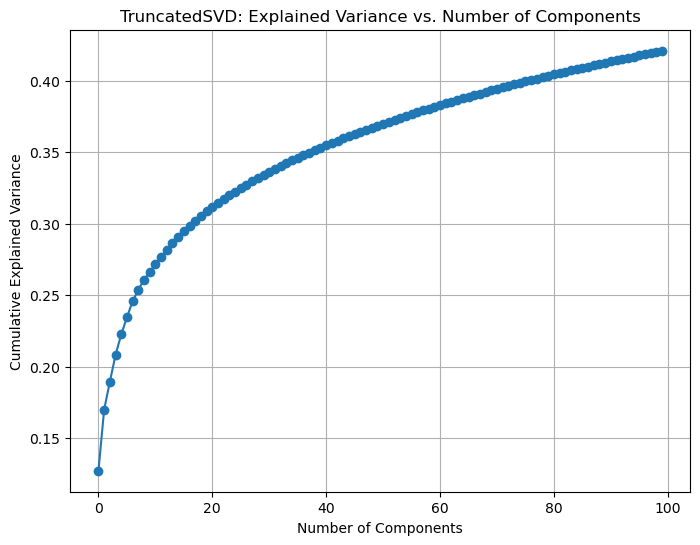

Оптимальное число компонент (для 90% дисперсии): 1


In [9]:
# 3. Обучаем SVD (например, на 100 компонент)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(ratings_csr)

# Строим график накопленной объяснённой дисперсии
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('TruncatedSVD: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Оптимальное число компонент (для 90% дисперсии): {optimal_components}")

In [10]:
print(svd.explained_variance_ratio_)
print("Суммарная объяснённая дисперсия:", np.sum(svd.explained_variance_ratio_))

[0.12714636 0.04276994 0.01942166 0.01888211 0.01427642 0.01204105
 0.01111132 0.00813921 0.00688492 0.00561164 0.00556328 0.00504842
 0.00499753 0.00482021 0.00415399 0.00412725 0.00354825 0.00349691
 0.00343389 0.00312327 0.00294858 0.00289923 0.00272115 0.00262711
 0.00255894 0.00251541 0.00244757 0.0023686  0.00228196 0.00223389
 0.00218057 0.00207525 0.00202688 0.00194128 0.00189778 0.00185302
 0.00181357 0.00180561 0.00177047 0.00172587 0.00164498 0.00162621
 0.00158946 0.00158323 0.00155453 0.00153355 0.00148958 0.00145526
 0.00144528 0.00142085 0.00141285 0.00139891 0.00136401 0.00133629
 0.00131746 0.00130235 0.00127148 0.00125722 0.00124909 0.00122671
 0.0012125  0.00119395 0.00118462 0.00116325 0.00114765 0.00114455
 0.00113347 0.00111178 0.00110115 0.001098   0.00107721 0.00105896
 0.00104209 0.00103874 0.00103479 0.00101604 0.00099837 0.00098936
 0.00098634 0.00096874 0.0009544  0.0009436  0.000942   0.00093512
 0.00092453 0.00092108 0.0009146  0.00089845 0.00089131 0.0008

In [11]:
# 4 Применяем SVD на выбраном кол-ве компонент(TruncatedSVD)

svd = TruncatedSVD(n_components=50, random_state=42)
user_matrix = svd.fit_transform(ratings_csr)  # размерность: (n_users × 50)
item_matrix = svd.components_.T                # размерность: (n_items × 50)

In [15]:
def get_svd_recommendations(user_id, user_encoder, item_encoder, svd_user_factors, svd_item_factors, movies, ratings, top_n=10):
    """
    Генерация рекомендаций для пользователя на основе SVD.
    """
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except ValueError:
        print(f"Пользователь {user_id} не найден.")
        return pd.DataFrame()

    user_vector = svd_user_factors[user_idx]  # shape: (50,)
    scores = np.dot(svd_item_factors, user_vector)  # shape: (n_items,)

    # Получаем уже просмотренные фильмы
    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].unique()
    rated_item_indices = item_encoder.transform(rated_movie_ids)

    # Исключаем просмотренные
    recommended_indices = [i for i in np.argsort(scores)[::-1] if i not in rated_item_indices][:top_n]

    # Декодируем в оригинальные movieId
    recommended_movie_ids = item_encoder.inverse_transform(recommended_indices)

    # Создаем DataFrame
    recommended_df = pd.DataFrame(recommended_movie_ids, columns=['movieId'])
    recommended_df = recommended_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

    return recommended_df


In [16]:
recommended_df = get_svd_recommendations(
    user_id='1',                              # или любой другой userId из original ratings
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    svd_user_factors=user_matrix,            # user-факторы: (n_users, 50)
    svd_item_factors=item_matrix,            # item-факторы: (n_items, 50)
    movies=movies,                           # DataFrame с фильмами
    ratings=ratings,                         # для фильтрации уже оцененных фильмов
    top_n=10
)
recommended_df

,movieId,title,genres
0,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
2,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
3,110,Braveheart (1995),Action|Drama|War
4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
6,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
7,356,Forrest Gump (1994),Comedy|Drama|Romance|War
8,2028,Saving Private Ryan (1998),Action|Drama|War
9,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


## Hdbscan

In [23]:
hdbscan_model = HDBSCAN(min_samples=20, cluster_selection_epsilon=0.01)  # Параметры можно настроить
clusters_hdb = hdbscan_model.fit_predict(movie_vectors_reduced)

In [24]:
unique_labels = np.unique(clusters_hdb)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Исключаем выбросы (-1)
num_outliers = np.sum(clusters_hdb == -1)

print(f"Количество кластеров: {num_clusters}")
print(f"Количество выбросов: {num_outliers}")

Количество кластеров: 2
Количество выбросов: 11285
